### Imports  & Parameters

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
# ugly workaround for imports
sys.path.append(os.path.split(os.getcwd())[0])

import numpy as np
import scipy as sp
import matplotlib
matplotlib.rcParams['animation.html'] = 'html5'

import matplotlib.pyplot as pl
import matplotlib.animation as animation
%matplotlib inline

from fit import *
from utils.prf import *

In [85]:
# parameters of analysis
n_pix = 20
rsq_threshold = 0.75

In [86]:
# settings that have to do with the data and experiment
nr_prf_parameters = 8
TR = 0.945
screen_distance = 225
screen_width = 39
nr_TRs = 462
timepoints = np.arange(nr_TRs) * TR
extent = [-5, 5]
stim_radius = 9.0
n_folds = 6

### Get Data

`prf_cv_fold_data` is the prf parameters, 
`rfs` are the pixel-based rf profiles.

data file found, returning local file ../data/V1.h5
Taking data corresponding to ['sub-012_task-mapper_acq-multiband_run-1_bold_B0_mcf_sg_psc', 'sub-012_task-mapper_acq-multiband_run-2_bold_B0_mcf_sg_psc', 'sub-012_task-mapper_acq-multiband_run-3_bold_B0_mcf_sg_psc', 'sub-012_task-mapper_acq-multiband_run-4_bold_B0_mcf_sg_psc', 'sub-012_task-mapper_acq-multiband_run-5_bold_B0_mcf_sg_psc', 'sub-012_task-mapper_acq-multiband_run-6_bold_B0_mcf_sg_psc'] from group /psc/V1.thresh_vol_dil.nii.gz
Taking data corresponding to ['sub-012_task-mapper_acq-multiband_run-1_bold_B0_mcf_sg_psc_av_loo', 'sub-012_task-mapper_acq-multiband_run-2_bold_B0_mcf_sg_psc_av_loo', 'sub-012_task-mapper_acq-multiband_run-3_bold_B0_mcf_sg_psc_av_loo', 'sub-012_task-mapper_acq-multiband_run-4_bold_B0_mcf_sg_psc_av_loo', 'sub-012_task-mapper_acq-multiband_run-5_bold_B0_mcf_sg_psc_av_loo', 'sub-012_task-mapper_acq-multiband_run-6_bold_B0_mcf_sg_psc_av_loo'] from group /loo/V1.thresh_vol_dil.nii.gz
Taking data correspo

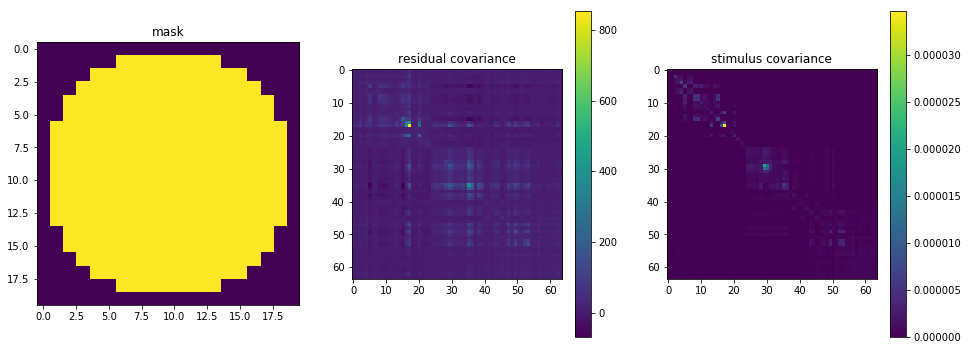

In [89]:
(prf_cv_fold_data, rfs, linear_predictor, 
 all_residuals_css, all_residual_covariance_css, 
 stimulus_covariance_WW, test_data, mask) = setup_data_from_h5(
                        data_file = '../data/V1.h5', 
                        n_pix=n_pix, 
                        extent=extent, 
                        stim_radius=stim_radius, 
                        screen_distance=screen_distance, 
                        screen_width=screen_width, 
                        rsq_threshold=rsq_threshold,
                        TR=TR,
                        cv_fold=0,
                        n_folds=n_folds)

f = pl.figure(figsize=(16,6))
s = f.add_subplot(131)
pl.imshow(mask);
s.set_title('mask')
s = f.add_subplot(132)
pl.imshow(all_residual_covariance_css)
s.set_title('residual covariance')
pl.colorbar()
s = f.add_subplot(133)
pl.imshow(stimulus_covariance_WW)
s.set_title('stimulus covariance')
pl.colorbar();

max tau: 48.4641067672 min tau: -1.06183395161
sigma: 0.304808976993 rho: 0.207528368329
summed squared distance: 4350782.18336


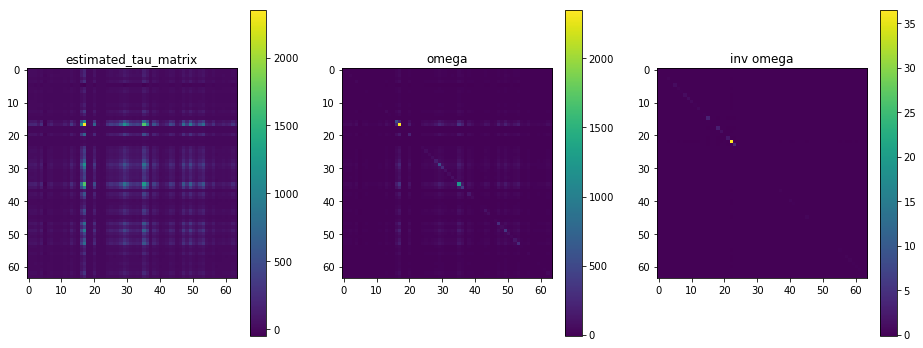

In [90]:
# estimate the covariance structure, which outputs all parameters
(estimated_tau_matrix, estimated_rho, 
 estimated_sigma, omega, 
 omega_inv, logdet) = fit_model_omega(
                                        observed_residual_covariance=all_residual_covariance_css, 
                                        featurespace_covariance=stimulus_covariance_WW,
                                        verbose=1
                                        )

f = pl.figure(figsize=(16,6))
s = f.add_subplot(131)
pl.imshow(estimated_tau_matrix)
s.set_title('estimated_tau_matrix')
pl.colorbar()
s = f.add_subplot(132)
pl.imshow(omega)
s.set_title('omega')
pl.colorbar()
s = f.add_subplot(133)
pl.imshow(omega_inv)
s.set_title('inv omega')
pl.colorbar();

In [91]:
# set up result array:
dm_pixel_logl_ratio = np.zeros((mask.sum(),test_data.shape[1]))

# and loop across timepoints
for t, bold in enumerate(test_data.T):
    dm_pixel_logl_ratio[:,t] = firstpass_decoder_independent_Ws(
                                        bold=bold, 
                                        logdet=logdet,
                                        omega_inv=omega_inv,
                                        linear_predictor=linear_predictor)

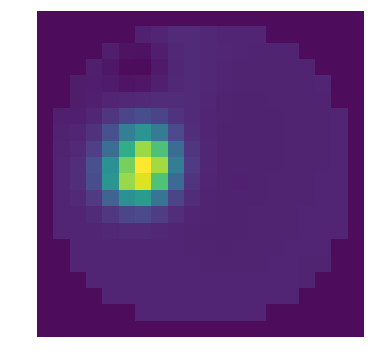

In [92]:
from IPython.display import HTML

fig = pl.figure(figsize=(6, 6))
ims = []

for t in range(dm_pixel_logl_ratio.shape[1]):
    stim_2d_array = np.zeros(mask.shape)
    stim_2d_array[mask] = dm_pixel_logl_ratio[:,t]


    #the video animation is currently not working for me. not sure how to fix it
    # fig.gca().add_patch(pl.Circle((int(n_pix/2), int(n_pix/2)), radius=8, facecolor='w',
    #                             edgecolor='k', fill=False, linewidth=3.0))
    extentz=[int(n_pix/2)-stim_radius,int(n_pix/2)+stim_radius,int(n_pix/2)-stim_radius,int(n_pix/2)+stim_radius,]
    # im = pl.imshow(dm_pixel_logl_ratio[:,:,t], animated=True, clim=[dm_pixel_logl_ratio.min(
    # ), dm_pixel_logl_ratio.max()], cmap='viridis', alpha=0.95)#, extent=extentz)    
    im = pl.imshow(stim_2d_array, animated=True, clim=[dm_pixel_logl_ratio.min(
    ), dm_pixel_logl_ratio.max()], cmap='viridis', alpha=0.95)#, extent=extentz)
    pl.axis('off')
    ims.append([im])

ani = animation.ArtistAnimation(
    fig, ims, interval=150, blit=True, repeat_delay=1500)

ani

# HTML(ani.to_html5_video())
# ani.save('out.avi')

In [44]:
np.eye?

In [93]:
decoded_image = np.zeros((mask.sum(),test_data.shape[1]))  
for t, bold in enumerate(test_data.T):
    decoded_image[:,t] = maximize_loglikelihood(
                                        starting_value=dm_pixel_logl_ratio[:,t],
                                        bold=bold,
                                        logdet=logdet,
                                        omega_inv=omega_inv,
                                        rfs=rfs, 
                                        prf_data=prf_cv_fold_data)
    

ValueError: cannot copy sequence with size 2 to array axis with dimension 276